# MOODLENS - PHASE 5 PROJECT

In [2]:
# Importing relevant libraries
import pandas as pd
import numpy as np   
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Loading the dataset
df = pd.read_csv(r"D:\moringa_school\CapStone\final_project\Data\reduced_reddit.csv")
df.head()

,subreddit,title,body,upvotes,created_utc,num_comments,label
0,teenagers,Day 18 of doing 50 push-ups,NaN,4.0,1.619357e+09,4.0,0.0
1,teenagers,There isn’t a better feeling than finishing yo...,Then your teacher hits you with that “ Good jo...,7.0,1.554103e+09,NaN,0.0
2,teenagers,LMAOOO I can only get this guy to talk to me i...,Yeahhh maybe not babe,4.0,1.649342e+09,12.0,0.0
3,teenagers,This isn't going to work out,NaN,236.0,1.417630e+09,33.0,0.0
4,teenagers,Am I the only guy who found it hurtful as a ch...,\n\nLike... why? How is that funny? How does ...,6.0,1.569280e+09,4.0,0.0


In [4]:
# Statistical Summary
df.describe()

,upvotes,created_utc,num_comments,label
count,98826.000000,9.882600e+04,94297.000000,98826.000000
mean,62.315555,1.566569e+09,15.217069,0.194443
std,937.347581,6.977745e+07,71.638197,0.395773
min,4.000000,1.202084e+09,1.000000,0.000000
25%,5.000000,1.552254e+09,4.000000,0.000000
50%,7.000000,1.578218e+09,7.000000,0.000000
75%,11.000000,1.611584e+09,14.000000,0.000000
max,62899.000000,1.672531e+09,7880.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          80371 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  94297 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.3+ MB


## Data Cleaning

In [6]:
# Checking for missing values in percentage
missing = (df.isnull().sum()/len(df))*100
missing

subreddit        0.000000
title            0.000000
body            18.674236
upvotes          0.000000
created_utc      0.000000
num_comments     4.582802
label            0.000000
dtype: float64

In [7]:
# Filling in missing values
df.dropna(subset=['body', 'num_comments'], inplace=True)

df.isnull().sum()

subreddit       0
title           0
body            0
upvotes         0
created_utc     0
num_comments    0
label           0
dtype: int64

In [8]:
# Checking for duplicates
df.duplicated().sum()

0

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77051 entries, 2 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     77051 non-null  object 
 1   title         77051 non-null  object 
 2   body          77051 non-null  object 
 3   upvotes       77051 non-null  float64
 4   created_utc   77051 non-null  float64
 5   num_comments  77051 non-null  float64
 6   label         77051 non-null  float64
dtypes: float64(4), object(3)
memory usage: 4.7+ MB


## EDA

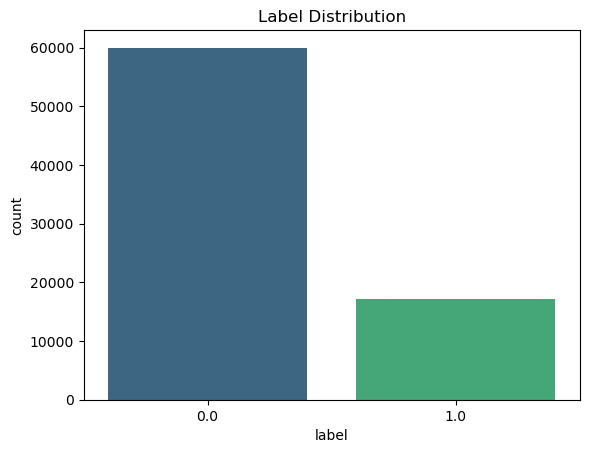

In [10]:
# Plot distribution for the labels
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Label Distribution')
plt.show()